In [ ]:
import pandas as pd
import numpy as np
import random
import string

# ==========================================
# 0. SETUP & HELPER FUNCTIONS (Sri Lankan Context)
# ==========================================
np.random.seed(42)
random.seed(42)

num_suspects = 1000
suspect_ids = [f'SLP-{i}' for i in range(1000, 1000 + num_suspects)]

# --- Sri Lankan Data Generators ---
first_names = ["Kamal", "Nuwan", "Mohamed", "Sanjeewa", "Ruwan", "Pradeep", "Tharindu", "Kasun", "Dilshan", "Mahesh", "Kumar", "Ravi", "Fathima", "Chatura", "Roshan"]
last_names = ["Perera", "Silva", "Fernando", "Bandara", "Wickramasinghe", "Khan", "Dissanayake", "Jayasinghe", "Rajaratnam", "Mendis", "Ekanayake", "Herath", "Gunawardena"]
cities = ["Colombo 07", "Gampaha", "Negombo", "Kandy", "Galle", "Matara", "Kurunegala", "Dehiwala", "Jaffna", "Batticaloa", "Nugegoda", "Mahara", "Kelaniya", "Moratuwa"]
streets = ["Temple Rd", "Main St", "Station Rd", "High Level Rd", "Galle Rd", "Kandy Rd", "Hospital Rd", "School Lane", "Church Rd"]

def generate_sl_name():
    return f"{random.choice(first_names)} {random.choice(last_names)}"

def generate_address():
    no = random.randint(1, 500)
    return f"No {no}, {random.choice(streets)}, {random.choice(cities)}"

def generate_nic():
    # Modern SL NIC (12 digits)
    return f"{random.randint(1970, 2006)}{random.randint(10000000, 99999999)}"

# ==========================================
# 1. GENERATE NETWORK (Obsidian Graph Links)
# ==========================================
linked_ids = []
relationship_types = []

for current_id in suspect_ids:
    # 30% chance of being part of a criminal network
    if random.random() < 0.3:
        num_links = random.randint(1, 3)
        others = random.sample([x for x in suspect_ids if x != current_id], num_links)
        linked_ids.append("; ".join(others))
        # Mix of relationships
        relationship_types.append(random.choice(['Gang Member', 'Gang Member', 'Family', 'Co-Accused']))
    else:
        linked_ids.append("None")
        relationship_types.append("None")

df_network = pd.DataFrame({
    'Suspect_ID': suspect_ids,
    'Linked_Associate_IDs': linked_ids,
    'Relationship_Type': relationship_types
})

# ==========================================
# 2. GENERATE CEMS (Detailed Demographics)
# ==========================================
df_cems = pd.DataFrame({
    'Suspect_ID': suspect_ids,
    'Full_Name': [generate_sl_name() for _ in range(num_suspects)],
    'NIC_Number': [generate_nic() for _ in range(num_suspects)],
    'Address': [generate_address() for _ in range(num_suspects)],
    'Age': np.random.randint(18, 65, num_suspects),
    'Gender': np.random.choice(['Male', 'Female'], num_suspects, p=[0.9, 0.1]),
    'Marital_Status': np.random.choice(['Single', 'Married', 'Divorced'], num_suspects, p=[0.4, 0.5, 0.1]),
    'Education_Level': np.random.choice(['O-Level', 'A-Level', 'Below Grade 8', 'Diploma'], num_suspects, p=[0.4, 0.3, 0.2, 0.1]),
    'Employment': np.random.choice(['Unemployed', 'Daily Wage Earner', 'Driver', 'Laborer', 'Self-Employed'], num_suspects),
    'Prior_Convictions': np.random.choice([0, 1, 2, 3, 4, 5], num_suspects, p=[0.4, 0.3, 0.15, 0.08, 0.05, 0.02]),
    'Last_Crime_Category': np.random.choice(['Theft', 'Drug Possession', 'Assault', 'Robbery', 'House Breaking', 'Fraud'], num_suspects)
})

# ==========================================
# 3. GENERATE TARGET (Realistic Recidivism Logic)
# ==========================================
# We calculate "True Risk" based on the data, then add randomness
is_gang = df_network['Linked_Associate_IDs'] != "None"
is_unemployed = df_cems['Employment'] == 'Unemployed'
is_drug_crime = df_cems['Last_Crime_Category'] == 'Drug Possession'
high_priors = df_cems['Prior_Convictions'] >= 3

# Base probability
risk_prob = np.random.uniform(0.1, 0.3, num_suspects)

# Add Risk Factors
risk_prob[is_gang] += 0.35          # Network is the biggest risk
risk_prob[is_unemployed] += 0.15    # Economic factor
risk_prob[is_drug_crime] += 0.20    # Drug offenders have high relapse
risk_prob[high_priors] += 0.25      # History repeats

# Add "Noise" (Random luck/life events)
risk_prob += np.random.normal(0, 0.05, num_suspects)

# Threshold: If risk > 60%, they Recidivate (1)
actual_recidivism = (risk_prob > 0.60).astype(int)

# *** IMPORTANT: Save the Target to the CEMS file ***
df_cems['Actual_Recidivism'] = actual_recidivism

# ==========================================
# 4. GENERATE BIOMETRICS (With Realistic Overlap)
# ==========================================
def generate_hash():
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=16))

biometric_hashes = [generate_hash() for _ in range(num_suspects)]
gait_scores = []

# Logic: Criminals usually score higher on "Suspicious Behavior" (0.7),
# but Innocents can also look nervous (0.3). There is overlap!
for is_recid in actual_recidivism:
    if is_recid == 1:
        # Criminals: Mean 0.75, SD 0.15
        score = np.random.normal(0.75, 0.15)
    else:
        # Innocents: Mean 0.35, SD 0.15
        score = np.random.normal(0.35, 0.15)

    # Clip to keep between 0.01 and 0.99
    score = max(0.01, min(0.99, score))
    gait_scores.append(score)

df_biometrics = pd.DataFrame({
    'Suspect_ID': suspect_ids,
    'Fingerprint_Hash_Data': biometric_hashes,
    'CCTV_Gait_Risk_Score': gait_scores
})

# ==========================================
# 5. SAVE FILES
# ==========================================
df_cems.to_csv('1_CEMS_Demographics.csv', index=False)
df_biometrics.to_csv('2_Biometric_Data.csv', index=False)
df_network.to_csv('3_Family_Network.csv', index=False)

print("SUCCESS: 3 Realistic Files Created!")
print(f"Total Suspects: {num_suspects}")
print(f"Total Recidivists (Target=1): {sum(actual_recidivism)}")
print("Sample Name:", df_cems['Full_Name'].iloc[0])
print("Sample Address:", df_cems['Address'].iloc[0])

SUCCESS: 3 Realistic Files Created!
Total Suspects: 1000
Total Recidivists (Target=1): 191
Sample Name: Mohamed Silva
Sample Address: No 296, Kandy Rd, Nugegoda


In [ ]:
import pandas as pd
import numpy as np

# ==========================================
# PHASE 1: DATA INTEGRATION
# ==========================================
print("--- STARTING PHASE 1: DATA INTEGRATION ---")

# 1. Load the Raw Data Streams
try:
    df_cems = pd.read_csv('1_CEMS_Demographics.csv')
    df_bio = pd.read_csv('2_Biometric_Data.csv')
    df_net = pd.read_csv('3_Family_Network.csv')
    print("1. Raw Files Loaded Successfully.")
except FileNotFoundError:
    print("ERROR: Please make sure you ran the 'Data Generation' code first!")

# 2. Merge into One Master Table
# We merge on 'Suspect_ID' to align the rows correctly
df_master = df_cems.merge(df_bio, on='Suspect_ID').merge(df_net, on='Suspect_ID')

print(f"2. Data Merged Successfully. Total Records: {len(df_master)}")

# ==========================================
# PHASE 2: FEATURE ENGINEERING (The Logic)
# ==========================================
# Convert the text list "SLP-105; SLP-109" into a number: "Network_Size"
def count_associates(links):
    if pd.isna(links) or links == "None":
        return 0
    return len(links.split(';'))

df_master['Network_Size'] = df_master['Linked_Associate_IDs'].apply(count_associates)
print("3. Feature Engineering Complete: 'Network_Size' column created.")

# ==========================================
# PHASE 3: THE "HUMAN READABLE" OUTPUT
# ==========================================
# We select the columns that tell the FULL story for Slide 10
display_cols = [
    'Suspect_ID',
    'Full_Name',              # <--- Shows it's a real person
    'Address',                # <--- Shows location data
    'Last_Crime_Category',    # <--- The crime they committed
    'Fingerprint_Hash_Data',  # <--- Shows biometric identity exists
    'CCTV_Gait_Risk_Score',   # <--- The AI Risk Score
    'Network_Size',           # <--- The calculated feature
    'Actual_Recidivism'       # <--- The Target (Answer Key)
]

print("\n--- PREVIEW OF MASTER TABLE (For Slide 10) ---")
# Only show the first 10 rows in the console to keep it clean
print(df_master[display_cols].head(10))

# Save the FULL dataset (1000 rows) to CSV for your Screenshot
df_master[display_cols].to_csv('4_Human_Readable_Master.csv', index=False)
print("\nSUCCESS: Saved '4_Human_Readable_Master.csv'. Open this file to take your screenshot!")

--- STARTING PHASE 1: DATA INTEGRATION ---
1. Raw Files Loaded Successfully.
2. Data Merged Successfully. Total Records: 1000
3. Feature Engineering Complete: 'Network_Size' column created.

--- PREVIEW OF MASTER TABLE (For Slide 10) ---
  Suspect_ID           Full_Name                        Address  \
0   SLP-1000       Mohamed Silva     No 296, Kandy Rd, Nugegoda   
1   SLP-1001       Mahesh Herath   No 235, Hospital Rd, Gampaha   
2   SLP-1002      Mahesh Bandara      No 86, Station Rd, Jaffna   
3   SLP-1003     Sanjeewa Perera      No 206, Church Rd, Matara   
4   SLP-1004    Kumar Rajaratnam     No 337, Station Rd, Jaffna   
5   SLP-1005  Sanjeewa Ekanayake    No 308, School Lane, Matara   
6   SLP-1006     Sanjeewa Perera       No 463, Kandy Rd, Jaffna   
7   SLP-1007   Nuwan Dissanayake   No 167, Kandy Rd, Kurunegala   
8   SLP-1008      Pradeep Herath  No 392, Hospital Rd, Moratuwa   
9   SLP-1009         Kasun Silva   No 372, Kandy Rd, Batticaloa   

  Last_Crime_Category Fi

In [ ]:
# ==========================================
# PHASE 4: PREPARING FOR THE AI (Encoding)
# ==========================================
print("\n--- STARTING PHASE 4: ENCODING FOR AI ---")

# 1. Define the Target (The Answer Key)
y = df_master['Actual_Recidivism']

# 2. DROP columns that are NOT predictive or are Raw Text
# We keep only the features that generalize (Age, Gender, Network_Size, etc.)
# We DROP specific identities (Name, Address, ID)
X_raw = df_master.drop([
    'Suspect_ID',             # Unique Identifier (Drop)
    'Full_Name',              # Unique Text (Drop)
    'Address',                # Unique Text (Drop)
    'NIC_Number',             # Unique ID (Drop) - if you generated this
    'Fingerprint_Hash_Data',  # Raw Biometric String (Drop - we use Gait Score)
    'Linked_Associate_IDs',   # Raw List of Names (Drop - we use Network_Size)
    'Relationship_Type',      # Text Description (Drop)
    'Actual_Recidivism'       # The Answer Key (Drop)
], axis=1, errors='ignore')   # 'ignore' prevents crash if a column is missing

print("1. Dropped non-predictive columns (Names, Addresses, IDs).")

# 3. ONE-HOT ENCODING: Turning Categories into Math
# This automatically finds text columns like 'Last_Crime_Category', 'Gender', 'Employment'
# and converts them into binary vectors (0s and 1s).
X_encoded = pd.get_dummies(X_raw, drop_first=True)

print("2. One-Hot Encoding Complete.")
print(f"   Original Features (Pre-Encoding): {X_raw.shape[1]}")
print(f"   New Encoded Features (Post-Encoding): {X_encoded.shape[1]}")

# ==========================================
# PHASE 5: THE "MACHINE VIEW" OUTPUT
# ==========================================
print("\n--- THE MACHINE VIEW (Encoded Input for Slide 11) ---")
# Show the first 5 rows of the mathematical matrix
print(X_encoded.head())

# Save this to CSV to show the complexity in your slide
X_encoded.to_csv('5_Machine_Encoded_Input.csv', index=False)
print("\nSUCCESS: Saved '5_Machine_Encoded_Input.csv'. Use this screenshot for Slide 11.")


--- STARTING PHASE 4: ENCODING FOR AI ---
1. Dropped non-predictive columns (Names, Addresses, IDs).
2. One-Hot Encoding Complete.
   Original Features (Pre-Encoding): 9
   New Encoded Features (Post-Encoding): 19

--- THE MACHINE VIEW (Encoded Input for Slide 11) ---
   Age  Prior_Convictions  CCTV_Gait_Risk_Score  Network_Size  Gender_Male  \
0   56                  2              0.390919             0         True   
1   46                  0              0.469099             2         True   
2   32                  0              0.406439             0         True   
3   60                  0              0.381147             0         True   
4   25                  1              0.383270             0         True   

   Marital_Status_Married  Marital_Status_Single  \
0                    True                  False   
1                   False                   True   
2                    True                  False   
3                    True                  False   
4

--- STARTING PHASE 5: MODEL TRAINING ---
Training XGBoost Model...
Training Complete.


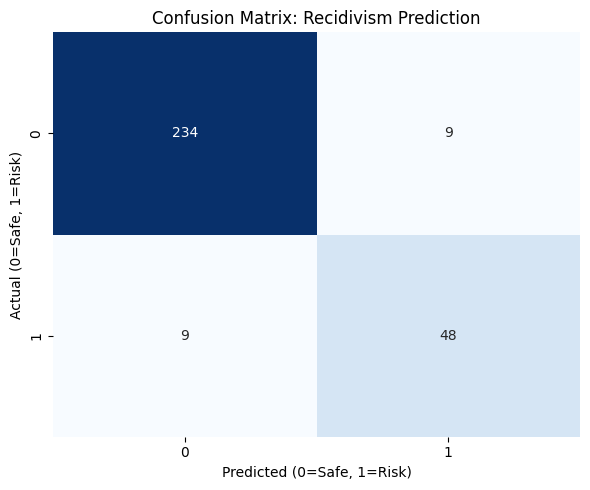

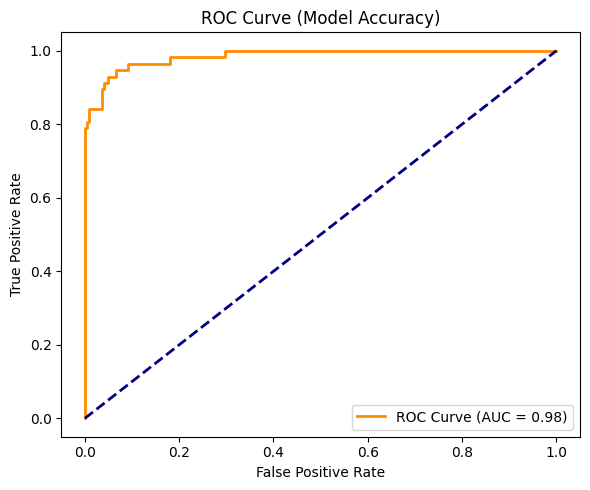

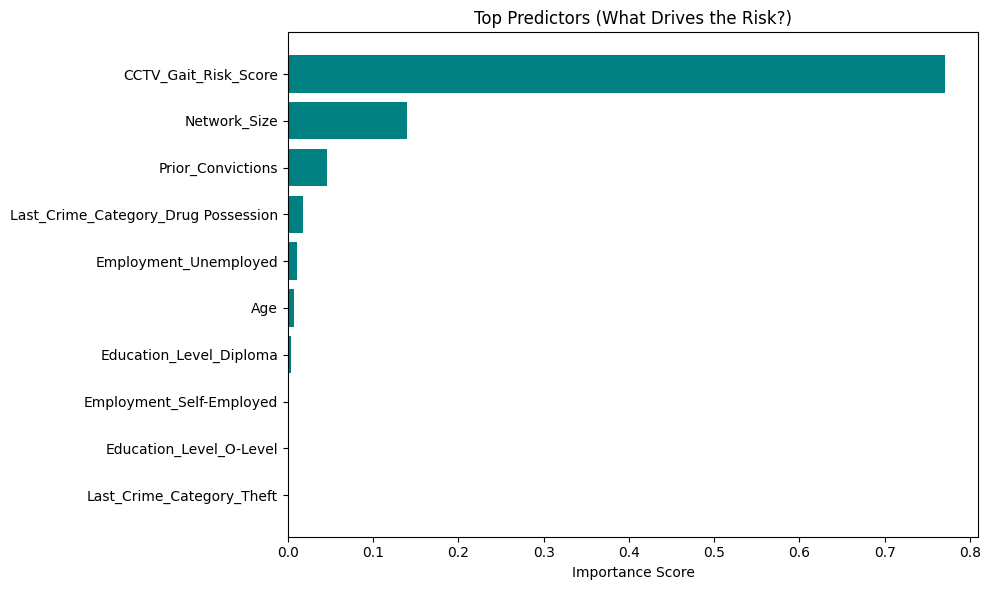


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       243
           1       0.84      0.84      0.84        57

    accuracy                           0.94       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.94      0.94      0.94       300



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# ==========================================
# PHASE 5: TRAINING & EVALUATION
# ==========================================
print("--- STARTING PHASE 5: MODEL TRAINING ---")

# 1. Split Data (70% Train, 30% Test)
# We use the 'stratify=y' option to make sure we have enough criminals in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Train XGBoost (Gradient Boosting)
print("Training XGBoost Model...")
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)
print("Training Complete.")

# 3. Generate Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# --- GRAPH 1: CONFUSION MATRIX (For Slide 14) ---
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Recidivism Prediction')
plt.xlabel('Predicted (0=Safe, 1=Risk)')
plt.ylabel('Actual (0=Safe, 1=Risk)')
plt.tight_layout()
plt.show()

# --- GRAPH 2: ROC CURVE (For Slide 13) ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Model Accuracy)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --- GRAPH 3: FEATURE IMPORTANCE (For Slide 15) ---
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot Top 10 Features
top_n = 10
sorted_idx = sorted_idx[-top_n:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center', color='teal')
plt.yticks(pos, np.array(X_encoded.columns)[sorted_idx])
plt.title('Top Predictors (What Drives the Risk?)')
plt.xlabel('Importance Score')
plt.tight_layout() # Ensures labels don't get cut off
plt.show()

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))

/tmp/ipython-input-1004316033.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis')


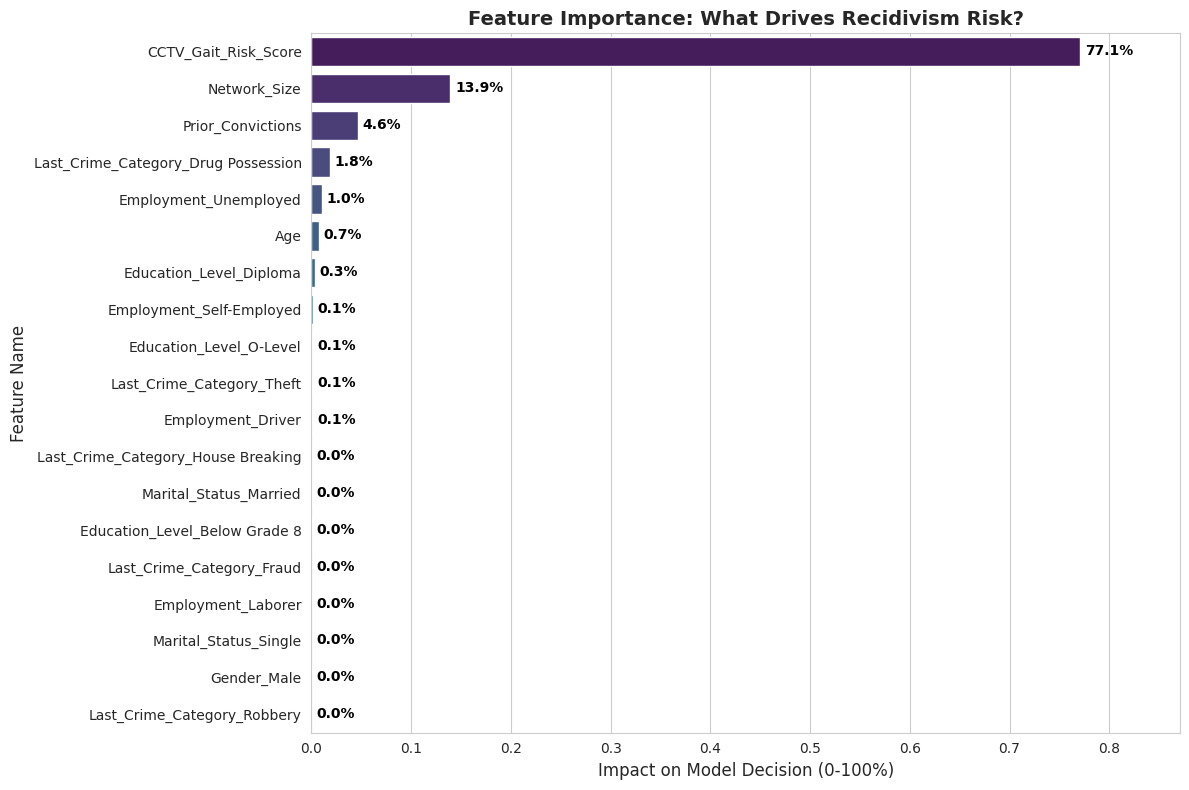

Graph Generated! Showing how much each factor contributes to the decision.


In [ ]:
# ==========================================
# FINAL GRAPH: FEATURE IMPORTANCE (Slide 16)
# ==========================================

# 1. Get Importance Scores
feature_importance = model.feature_importances_
feature_names = X_encoded.columns

# 2. Create a DataFrame for easier plotting
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# 3. Sort by Importance (Highest on top)
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# 4. Plotting
plt.figure(figsize=(12, 8)) # Made it taller to fit all rows
# Use a color palette where the top features are darker/more visible
sns.set_style("whitegrid")
ax = sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis')

# 5. Add Percentage Labels to Each Bar
for i, v in enumerate(df_importance['Importance']):
    # Convert score to percentage (e.g., 0.45 -> "45.0%")
    ax.text(v + 0.005, i + 0.1, f'{v*100:.1f}%', color='black', fontweight='bold', fontsize=10)

# 6. Final Polish
plt.title('Feature Importance: What Drives Recidivism Risk?', fontsize=14, fontweight='bold')
plt.xlabel('Impact on Model Decision (0-100%)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.xlim(0, max(df_importance['Importance']) + 0.1) # Add space for labels
plt.tight_layout()

plt.show()
print("Graph Generated! Showing how much each factor contributes to the decision.")